In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.1.2


## Data (preparing and loading)

Data can be almost anything... in machine learning
* Excel spreadsheets
* Images
* Videos
* Audio
* DNA
* Text

Two parts of ML
1. Get data into numerical representation
2. Build model to learn patterns

### Let's create some known data using the linear regression forumla!

Make a straight line with known **parameters**

In [3]:
# Create parameters
weight = 0.69
bias = 0.420

# Create some data

start = 0.0
end = 1.0
step = 0.02

X = torch.arange(start, end+step, step).unsqueeze(dim=1)
y = weight * X + bias

### Splitting data into training and test sets
One of most important concepts

Let's create training and test sets with our data

In [4]:
train_split = int(0.8 * len(X))

In [5]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(f"Number of train samples: { len(X_train) } features, { len(y_train) } labels.")
print(f"Number of test samples: { len(X_test) } features, { len(y_test) } labels.")

Number of train samples: 40 features, 40 labels.
Number of test samples: 11 features, 11 labels.


## Visualising the data

In [6]:
def plot_prediction(train_data, train_labels, test_data, test_labels, predictions = None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", label="Predictions")

    plt.legend(prop={"size" : 14})

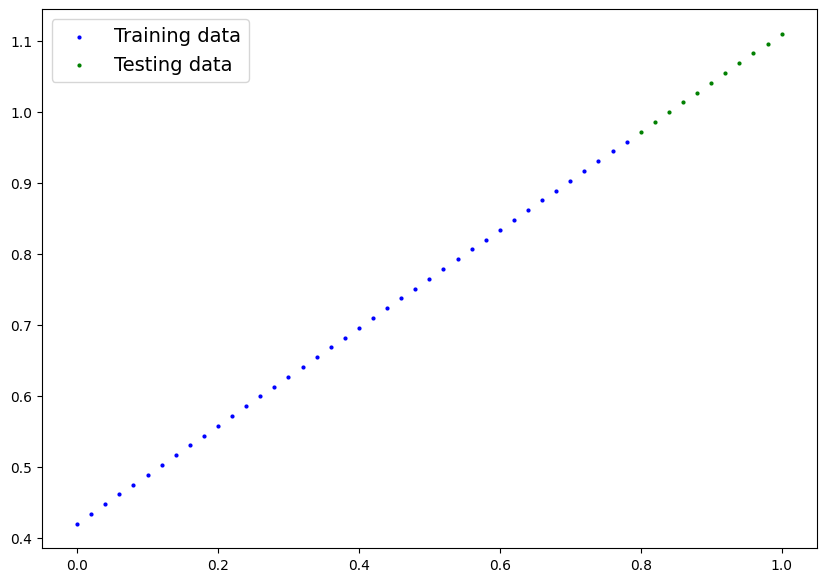

In [7]:
plot_prediction(X_train, y_train, X_test, y_test)

## Build model

In [8]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(
                1,
                requires_grad=True,
                dtype=torch.float)
        )
        self.bias = nn.Parameter(
            torch.randn(
                1,
                requires_grad=True,
                dtype=torch.float)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias # Linear regression formula

### PyTorch model building

* Torch.nn contains all the building blocks for computational graphs.
* torch.nn.Parameter - what parameters should our model try and learn
* torch.nn.Module - base class for all neural network modules
* torch.optim - this is where the optimzers in PyTorch live
* def forward() - All nn.Module subclasses require overwriting forward, this method defines what happens in forward computation

### Checking contents of a pytorch model

In [9]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()

In [10]:
def print_model_params(model : nn.Module):
    params = model_0.state_dict()
    print("Parameters:")
    for k in params:
        print(f"{k} : {params[k]}")
    print("\n")

In [11]:
print_model_params(model_0)

Parameters:
weights : tensor([0.3367])
bias : tensor([0.1288])




### Making prediction using `torch.inference_mode()`

In [12]:
with torch.inference_mode():
    y_preds = model_0(X_test)

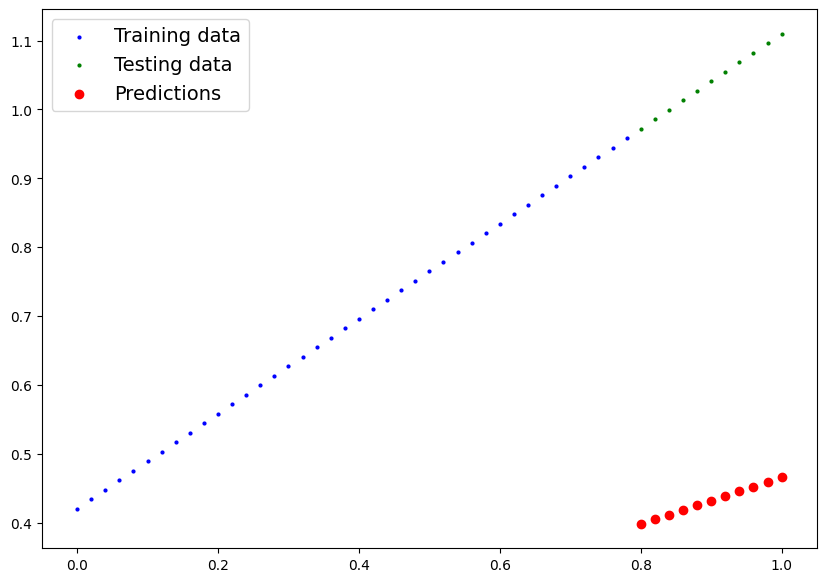

In [13]:
plot_prediction(X_train, y_train, X_test, y_test, y_preds)

In [14]:
# Setup loss function
loss_fn = nn.L1Loss()

In [15]:
# Setup optimizer
optimizer = torch.optim.SGD(
    params = model_0.parameters(),
    lr = 0.01
)

### Building a train and test loop

#### Training loop

1. Loop through the data
2. Forward pass (this involves data throug the model's `forward()` functions.
3. Calculate the loss (compare forward pass predictions to ground truth labels)
4. Optimizer zero grad
5. Loss backwards - move backwards through the network to calculate the gradients of each parameters of our model with respect to the loss (**backpropagation**)
6. Optimizer stet - use optimizer to adjust our model's parametsers to try and improve loss (**gradient descent**)

In [16]:
torch.manual_seed(42)

epochs = 150
losses = np.empty(epochs)
test_losses = np.empty(epochs)

for epoch in range(epochs):
    model_0.train() # Sets all parameters that require gradients to require gradients
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    losses[epoch] = loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)
        test_losses[epoch] = test_loss
    if epoch % 10 == 0 or epoch == epochs-1:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.42898136377334595 | Test loss: 0.5956592559814453
Epoch: 10 | Loss: 0.3137713372707367 | Test loss: 0.46055933833122253
Epoch: 20 | Loss: 0.1985614001750946 | Test loss: 0.32545945048332214
Epoch: 30 | Loss: 0.08399614691734314 | Test loss: 0.19136856496334076
Epoch: 40 | Loss: 0.042210500687360764 | Test loss: 0.11566856503486633
Epoch: 50 | Loss: 0.03577398508787155 | Test loss: 0.08837369084358215
Epoch: 60 | Loss: 0.03223606199026108 | Test loss: 0.0771736204624176
Epoch: 70 | Loss: 0.02878224477171898 | Test loss: 0.06804048269987106
Epoch: 80 | Loss: 0.025345642119646072 | Test loss: 0.059596385806798935
Epoch: 90 | Loss: 0.021908756345510483 | Test loss: 0.051841188222169876
Epoch: 100 | Loss: 0.018480312079191208 | Test loss: 0.04339705780148506
Epoch: 110 | Loss: 0.015042031183838844 | Test loss: 0.03495290130376816
Epoch: 120 | Loss: 0.011606818065047264 | Test loss: 0.02719775028526783
Epoch: 130 | Loss: 0.00817722175270319 | Test loss: 0.01875360496342182

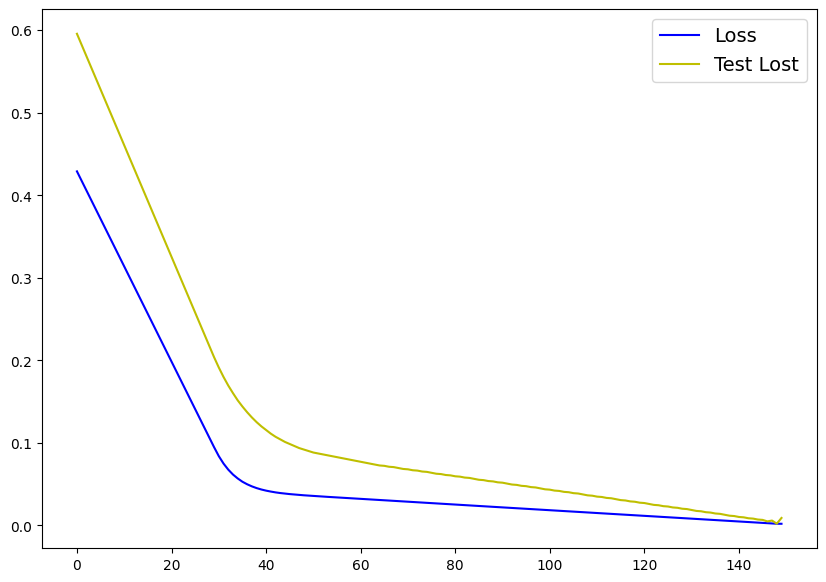

In [17]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(losses)), losses, c="b", label="Loss")
plt.plot(np.arange(len(test_losses)), test_losses, c="y", label="Test Lost")
plt.legend(prop={"size" : 14})

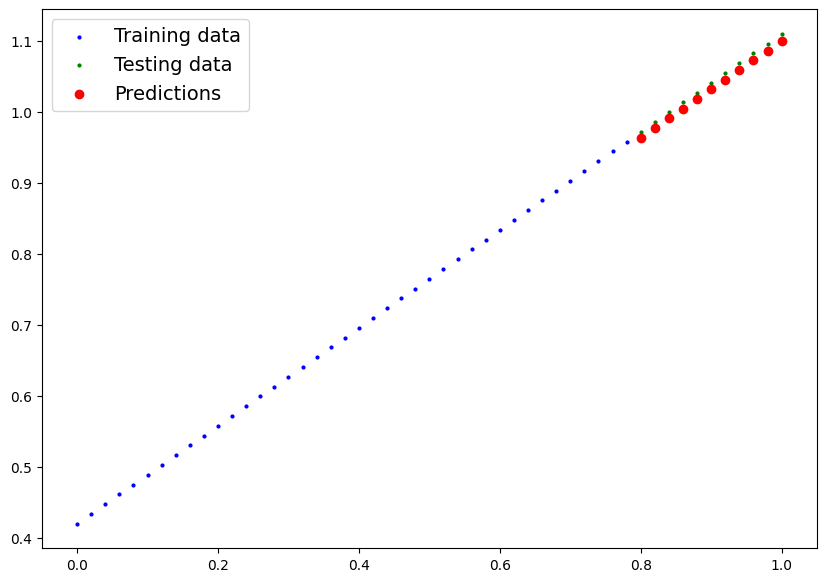

In [18]:
with torch.inference_mode():
    y_preds = model_0(X_test)
plot_prediction(X_train, y_train, X_test, y_test, y_preds)

### Save a model in PyTorch

3 Main methods for saving and loading models in PyTorch
1. `torch.save()` - saves torch object in pickle format
2. `torch.load()`- allows to load a saved PyTorch ojbect
3. `torch.nn.Module.loade_state_dict()` - allows to load a model's saved state dictionary

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6812])), ('bias', tensor([0.4188]))])

In [20]:
MODEL_PATH = Path("../saved_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to: ../saved_models/01_pytorch_workflow_model_0.pth


In [24]:
model_load = LinearRegressionModel()
model_load.load_state_dict(torch.load(MODEL_SAVE_PATH))
print(model_load.state_dict())
model_load.eval()

OrderedDict([('weights', tensor([0.6812])), ('bias', tensor([0.4188]))])


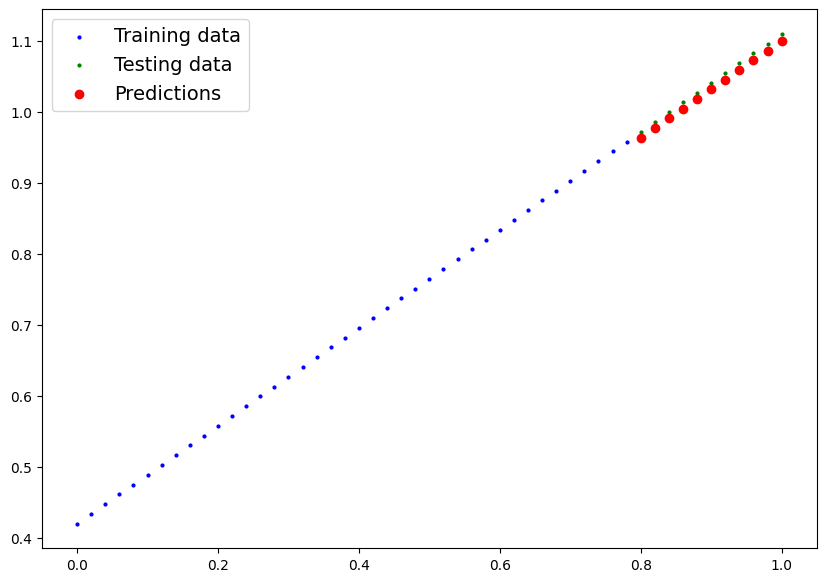

In [23]:
with torch.inference_mode():
    y_preds = model_load(X_test)
plot_prediction(X_train, y_train, X_test, y_test, y_preds)